# Creación de un Modelo Predictivo con Procesamiento de Lenguaje Natural (NLP) en PySpark  para las puntuaciones de las reviews de Amazon

EL objetivo de este notebook es la creación de un flujo de trabajo completo de NLP para predecir de 1 a 5 estrellas en reseñas de Amazon, contando con un total de 3.6 millones de muestras.  
Para ello se ha utilizado PySpark desde la breve limpieza y análisis exploratorio hasta la creación y evaluación de un modelo de stacking compuesto por 2 capas.

**Estructura**
- Análisis Exploratorio de Datos (EDA)  
- Procesamiento de Texto: tokenización, n-gramas y TF-IDF  
- Modelado en dos capas (modelos base + modelo final)  
- Evaluación: MAE y matriz de confusión  
- Conclusiones y siguientes pasos

## Análisis de Datos Exploratorio

In [2]:
import findspark
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, NGram, StopWordsRemover, Tokenizer, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType, StructField, StructType
from sklearn.metrics import confusion_matrix

### Conexión con Apache Spark

In [2]:
findspark.init()
spark = SparkSession.builder \
    .appName("Ruben Valverde Amazon NLP") \
    .master("local[*]") \
    .config("spark.driver.memory", "14g") \
    .getOrCreate()

### Importación de los datos

El dataset se compone de 3 columnas: 
1. La puntuación del producto
2. El titulo de la review
3. La review, donde el cliente expresa su opinión del producto

In [3]:
schema = StructType([
    StructField("rating", IntegerType()),
    StructField("title", StringType()),
    StructField("review", StringType())
    ])

In [5]:
train_df = spark.read.csv("datasets/train.csv", header=False, schema=schema, sep=",", nanValue=None)
train_df.show(2, truncate=False)

+------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|title             |review                                                                                                                                                                                                      |
+------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|3     |more like funchuck|"Gave this to my dad for a gag gift after directing ""Nunsense                                                                                                                                              |
|5     |Inspiring         |I hope a lot of people hear this cd. We n

In [7]:
test_df = spark.read.csv("datasets/test.csv", header=False, schema=schema, sep=",", nanValue=None)

In [8]:
train_df.printSchema()

root
 |-- rating: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- review: string (nullable = true)



In [9]:
train_df.count()

3000000

In [10]:
test_df.count()

650000

**Observaciones**  
El dataset de entrenamiento contiene 3 millones de filas y el test 650 mil

In [11]:
train_df.select("rating").distinct().orderBy("rating").show()

+------+
|rating|
+------+
|     1|
|     2|
|     3|
|     4|
|     5|
+------+



Las puntuaciones de los productos van del 1 al 5

Debido a que los modelos a vecces predecian 0 se le restará 1 a todas las puntuaciones.

In [12]:
train_df = train_df.withColumn("rating", train_df["rating"] -1)
test_df = test_df.withColumn("rating", test_df["rating"] -1)

train_df.select("rating").distinct().orderBy("rating").show()

+------+
|rating|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
+------+



**Conteo de nulos**

In [13]:
train_df.filter(train_df["rating"].isNull() | train_df["title"].isNull() | train_df["review"].isNull()).count()

65

In [14]:
test_df.filter(test_df["rating"].isNull() | test_df["title"].isNull() | test_df["review"].isNull()).count()

6

**Observaciones**  
1. El dataset de entrenamiento contiene 65 filas con nulos.  
2. El dataset de test contiene 6 filas con nulos.  

Dado el pequeño número de nulos, las filas se eliminaran.

In [15]:
train_df = train_df.na.drop()
train_df.count()

2999935

In [16]:
test_df = test_df.na.drop()
test_df.count()

649994

### Distribución de las Puntuaciones

In [17]:
sns.set_theme(style="whitegrid")

In [18]:
ratings_pd = train_df.select("rating").toPandas()

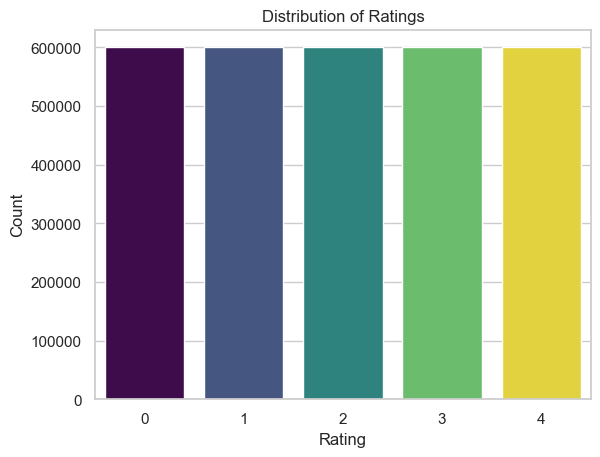

In [19]:
sns.countplot(data=ratings_pd, x="rating", palette="viridis", hue="rating", legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

**Observaciones**  
Todas las puntuaciones están perfectamente balanceadas

## Procesamiento de Datos

En esta sección se creará un pipeline para transformar los títulos y reviews en un formato más adecuado para el modelo.

**Tokenización**  
PySpark convierte por defecto las palabras a minuscula por lo que no es necesario realizar la transformación previamente

In [20]:
tokenizer_title = Tokenizer(inputCol="title", outputCol="title_words")
tokenizer_review = Tokenizer(inputCol="review", outputCol="review_words")

**Eliminación de palabras con poco significado**  
Ejemplos: the, of, from, for

In [21]:
stop_words_remover_title = StopWordsRemover(inputCol="title_words", outputCol="title_lemmatized")
stop_words_remover_review = StopWordsRemover(inputCol="review_words", outputCol="review_lemmatized")

**N-Gramas**  
Conjuntos de n palabras, a veces dos o tres palabras juntas pueden tener un único significado.  
Ejemplo: "Media Naranja"

In [22]:
two_grams_title = NGram(n=2, inputCol="title_lemmatized", outputCol="title_2grams")
two_grams_review = NGram(n=2, inputCol="review_lemmatized", outputCol="review_2grams")

**Term Frecuency - Inverse Document Frecuency (tf-idf)**  
Le da una puntuación de relevancia a cada palabra teniendo en cuenta el nº de veces que aparece en la review y en todo el dataframe.

In [23]:
count_title = CountVectorizer(inputCol="title_lemmatized", outputCol="title_count", vocabSize=100)
count_review = CountVectorizer(inputCol="review_lemmatized", outputCol="review_count", vocabSize=400)

count_title_2grams = CountVectorizer(inputCol="title_2grams", outputCol="title_2grams_count", vocabSize=100)
count_review_2grams = CountVectorizer(inputCol="review_2grams", outputCol="review_2grams_count", vocabSize=400)

idf_title = IDF(inputCol="title_count", outputCol="title_tfidf")
idf_review = IDF(inputCol="review_count", outputCol="review_tfidf")

idf_title_2grams = IDF(inputCol="title_2grams_count", outputCol="title_2grams_tfidf")
idf_review_2grams = IDF(inputCol="review_2grams_count", outputCol="review_2grams_tfidf")

**Vector Assembler**  
Une varias columnas en una formando un vector, es el formato utilizado por los modelo de ML de PySpark

In [24]:
assembler = VectorAssembler(
    inputCols=["title_tfidf", 
               "title_2grams_tfidf",
               "review_tfidf", 
               "review_2grams_tfidf"],
    outputCol="features")

**Cambio de nombre**  
Para un entrenamiento más estandar.

Tambien se ponen los dataframe en cache para aumentar la velocidad de entrenamiento

In [25]:
train_df = train_df.withColumnRenamed("rating", "label")
test_df = test_df.withColumnRenamed("rating", "label")

**Pipeline**  
Creo una pipeline añadiendo todas la fases de procesamiento de los datos

In [26]:
pipeline_nlp = Pipeline(stages=[
    tokenizer_title,
    tokenizer_review,
    stop_words_remover_title,   
    stop_words_remover_review,
    two_grams_title,
    two_grams_review,
    count_title,
    count_review,
    count_title_2grams,
    count_review_2grams,
    idf_title,
    idf_review,
    idf_title_2grams,
    idf_review_2grams,
    assembler
])

In [27]:
pipeline_nlp_model = pipeline_nlp.fit(train_df)

In [28]:
train_df_transformed = pipeline_nlp_model.transform(train_df)
test_df_transformed = pipeline_nlp_model.transform(test_df)

## Modelo predictivo

Inicialmente se iba a utilizar la versión de XGB para Spark, sin embargo ha dado problemas de compatibilidad, en sustitución se ha creado un meta-modelo con cuatro modelos nativos de PySpark con soporte para multiclase.

**Capa 1**  
Se han utilizado `Random Forest`, `Naive Bayes` y una pequeña `Red Neuronal`.

**Capa Final**   
Se utilizan las probabilidades que ha dado cada modelo para cada label en datos no vistos junto a los features en una `Regresión Logística`.

**Tipo de modelo**  
Dado que la puntuación que pueden poner los usuarios es discreta, es decir no pueden asignarle una puntuación de 4.6 a un producto, se ha optado por modelos de clasificación.

**Metricas**  
Las puntuaciones sí siguen un order, siendo 1 lo peor y 5 lo mejor sería lógico penalizar más cuanto mayor sea el error, por ejemplo si el valor real es 2 tiene sentido penalizar menos si el modelo predice 1 que si predice 5. Por ese motivo la primera metrica escogida ha sido el Error Medio Absoluto a pesar de que se trate de un modelo de clasificación.  
Al precedir valores discretos tambien se ha visualizado una matriz de confusión con la cual poder observar con mayor facilidad su desempeño en cada puntuación.

**Capa 1**

In [29]:
nb = NaiveBayes(
    featuresCol="features",
    labelCol="label",
    probabilityCol="probability_nb",
    predictionCol="prediction_nb",
    rawPredictionCol="rawPrediction_nb",
    smoothing=0.9)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    probabilityCol="probability_rf",
    predictionCol="prediction_rf",
    rawPredictionCol="rawPrediction_rf",
    seed=27
)
nn = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    probabilityCol="probability_nn",
    predictionCol="prediction_nn",
    rawPredictionCol="rawPrediction_nn",
    maxIter=100,
    layers=[1000, 128, 32, 5],
    seed=27)

**Capa 2**

In [30]:
log = LogisticRegression(
    featuresCol="features_2",
    labelCol="label",
    predictionCol="prediction",
    maxIter=1000,
    regParam=0.01,
    elasticNetParam=0.8)

**Clase MetaModelo**  
El objetivo es crear una clase que agrupe todo el proceso del metamodelo

In [ ]:
class MetaModelo:
    """
    Modelo que combina varios modelos base en la primera capa y un modelo en la segunda y última capa.

    Parametros:
    modelos_base: Lista de modelos para la primera capa.
    modelo_stacker: Modelo final que combina las predicciones de los modelos base con los propios datos.
    ratio: Proporción de datos para entrenar la primera capa y la segunda capa.
    seed: Semilla para la aleatoriedad en la división de datos.
    """

    def __init__(self, modelos_base=[nb, rf, nn] ,modelo_stacker=log, ratio=[0.35, 0.65], seed=27):

        self.modelos_base = modelos_base
        self.modelo_stacker = modelo_stacker
        self.ratio = ratio
        self.seed = seed

        
    def fit(self, df): 
        df_1, df_2 = df.randomSplit(self.ratio, seed=self.seed)
        df_1.cache()
        df_2.cache()

        self.ensamblador = VectorAssembler(
            inputCols=[modelo.getProbabilityCol() for modelo in self.modelos_base],
            outputCol=self.modelo_stacker.getFeaturesCol()
        )

        self.pipeline = Pipeline(stages=self.modelos_base + [self.ensamblador])
        self.pipeline_model = self.pipeline.fit(df_1)
        df_2_transformed = self.pipeline_model.transform(df_2)

        self.modelo_final = self.modelo_stacker.fit(df_2_transformed)         

        return self
        
    def transform(self, df):

        df_transformed = self.pipeline_model.transform(df)
        df_final = self.modelo_final.transform(df_transformed)

        return df_final
    
    def evaluate(self, df, metrica="mae"):
        predicciones = self.transform(df)
        evaluator = RegressionEvaluator(labelCol=self.modelo_stacker.getLabelCol(), predictionCol=self.modelo_stacker.getPredictionCol(), metricName=metrica)
        error = evaluator.evaluate(predicciones)

        return error 


In [32]:
meta_modelo = MetaModelo()
meta_modelo.fit(train_df_transformed)

## Evaluación

### Error Medio Absoluto (MAE)

In [33]:
train_mae = meta_modelo.evaluate(train_df_transformed)
test_mae = meta_modelo.evaluate(test_df_transformed)

print("MAE en el conjunto de entrenamiento:", train_mae)
print("-----------------------------------------------")
print("MAE en el conjunto de prueba:", test_mae) 

MAE en el conjunto de entrenamiento: 0.8372781410263889
-----------------------------------------------
MAE en el conjunto de prueba: 0.83779850275541


### Matriz de Confusión
Se visualizan las predicciones del modelo vs las puntuaciones reales

**Observaciones**  
El modelo tiene un error medio absoluto de 0.835 en el conjunto de entrenamiento y de 0.836 en el conjunto de prueba.  
Esto indica que hay overfitting.

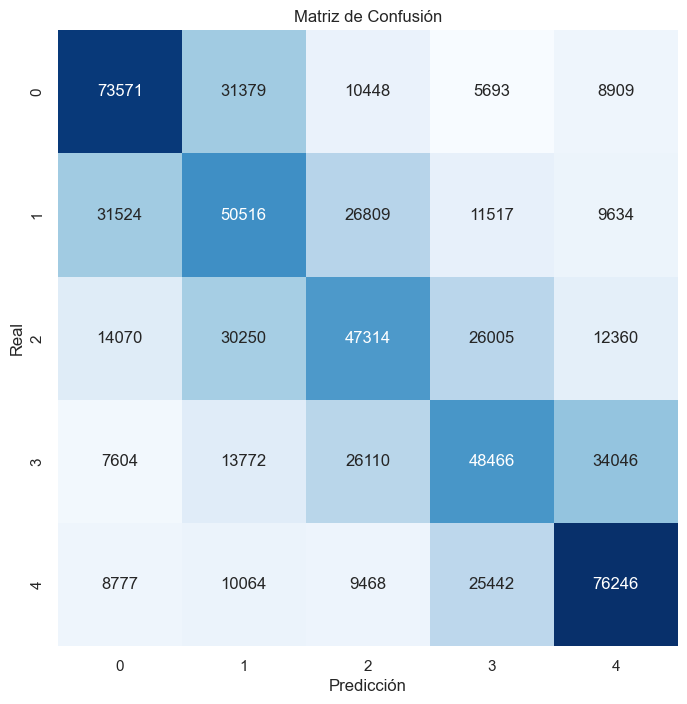

In [34]:
test_predictions = meta_modelo.transform(test_df_transformed)

y_true = test_predictions.select("label").toPandas()
y_pred = test_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

**Observaciones**  
Se aprecia que la mayoria de las predicciones son correctas, estando el grueso en la diagonal y con pocas predicciones "muy erradas", siendo las dos puntuaciones donde ha obtenido un mejor desempeño en los extremos, cuando el producto es o muy malo o muy bueno.  
Teniendo esto en cuenta el modelo no parece presentar problemas de sesgo.

## Conclusión  
PySpark ha hecho factible manejar millones de filas en un tiempo razonable (aunque con bastantes bugs).   
Se han procesado los titulos y comentarios de los usuarios en un pipeline para luego crear un pequeño meta-modelo con una tasa de acierto razonable.

Después de bastantes ajustes y pruebas el tiempo de ejecución total del notebook ronda los 40 minutos.  

Con una mayor capacidad de computación se podrían integrar nuevas caraterísticas como un tri-grama para las reviews, realizar un ajuste de hiperparámetros o aprovechar la compatibilidad con PyTorch y crear una Red Neuronal más compleja y asi alcanzar unas predicciones aún más acertadas.